In [1]:
%load_ext autoreload

In [2]:
%autoreload

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200
import seaborn as sns
sns.set(rc={"figure.dpi":200, 'savefig.dpi':200})
sns.set_context('notebook')
sns.set_style("ticks")
import math

sns.set_style('darkgrid')

from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import sklearn as skl
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
def list_directory_tree_with_os_walk(starting_directory):
    for root, directories, files in os.walk(starting_directory):
        print(f"Directory: {root}")
        for file in files:
            print(f"  File: {file}")

list_directory_tree_with_os_walk('.')

Directory: .
  File: Cleaning.ipynb
  File: Forecasting A.ipynb
  File: Forecasting B.ipynb
  File: Forecasting C.ipynb
  File: full_arimax_A.csv
  File: full_arimax_B.csv
  File: full_arimax_C.csv
  File: full_arimax_test_213_0.csv
  File: Getting csv.ipynb
  File: Neg_Pow_Inc_0.csv
  File: Test File.ipynb
Directory: .\data
  File: Readme.md
  File: read_files.ipynb
  File: sample_submission.csv
  File: test.csv
Directory: .\data\A
  File: train_targets.parquet
  File: X_test_estimated.parquet
  File: X_train_estimated.parquet
  File: X_train_observed.parquet
Directory: .\data\B
  File: train_targets.parquet
  File: X_test_estimated.parquet
  File: X_train_estimated.parquet
  File: X_train_observed.parquet
Directory: .\data\C
  File: train_targets.parquet
  File: X_test_estimated.parquet
  File: X_train_estimated.parquet
  File: X_train_observed.parquet
Directory: .\Plots
  File: 1 pv_measurement.png
  File: absolute_humidity_2mgm3.png
  File: air_density_2mkgm3.png
  File: ceiling_he

In [4]:
train_c = pd.read_parquet('data/C/train_targets.parquet')

X_train_estimated_c = pd.read_parquet('data/C/X_train_estimated.parquet').drop("date_calc", axis=1)

X_train_observed_c = pd.read_parquet('data/C/X_train_observed.parquet')

X_test_estimated_c = pd.read_parquet('data/C/X_test_estimated.parquet').drop("date_calc", axis=1)

train_c_observed_part = train_c[train_c["time"] <= X_train_estimated_c["date_forecast"].min()]
train_c_estimated_part = train_c[train_c["time"] >= X_train_estimated_c["date_forecast"].min()].reset_index(drop = True)

train_c_estimated_part = pd.concat([train_c_estimated_part, pd.DataFrame([['2023-05-01 00:00:00',0]], columns=train_c.columns)], ignore_index=True)
train_c_estimated_part["time"] = train_c_estimated_part["time"].astype("datetime64[us]")

X_train_observed_c_clean = pd.DataFrame(columns=X_train_observed_c.columns)
for i in range(len(train_c_observed_part)-1):
    mean_values_observed = np.array(X_train_observed_c[(X_train_observed_c["date_forecast"] >= train_c_observed_part["time"][i]) & (X_train_observed_c["date_forecast"] <= train_c_observed_part["time"][i+1])].mean())
    mean_values_observed[0] = train_c_observed_part["time"][i]
    X_train_observed_c_clean = pd.concat([X_train_observed_c_clean, pd.DataFrame([mean_values_observed], columns=X_train_observed_c.columns)], ignore_index=True)
    # print(i)
X_train_observed_c_clean["date_forecast"] = X_train_observed_c_clean["date_forecast"].astype("datetime64[us]")

X_train_estimated_c_clean = pd.DataFrame(columns=X_train_estimated_c.columns)
for i in range(len(train_c_estimated_part)-1):
    mean_values_estimated = np.array(X_train_estimated_c[(X_train_estimated_c["date_forecast"] >= train_c_estimated_part["time"][i]) & (X_train_estimated_c["date_forecast"] <= train_c_estimated_part["time"][i+1])].mean())
    mean_values_estimated[0] = train_c_estimated_part["time"][i]
    X_train_estimated_c_clean = pd.concat([X_train_estimated_c_clean, pd.DataFrame([mean_values_estimated], columns=X_train_estimated_c.columns)], ignore_index=True)
    # print(i)
X_train_estimated_c_clean["date_forecast"] = X_train_estimated_c_clean["date_forecast"].astype("datetime64[us]")

X_train_c_clean = pd.concat([X_train_observed_c_clean, X_train_estimated_c_clean], ignore_index=True)

test_c_dates = pd.DataFrame(columns=train_c.columns).drop(["pv_measurement"],axis=1)
for i in range(len(X_test_estimated_c)):
    if (i%4 == 0):
        test_c_dates = pd.concat([test_c_dates, pd.DataFrame([X_test_estimated_c["date_forecast"][i]], columns=test_c_dates.columns)], ignore_index=True)
test_c_dates = pd.concat([test_c_dates, pd.DataFrame(['2023-07-04 00:00:00'], columns=test_c_dates.columns)], ignore_index=True)
test_c_dates["time"] = test_c_dates["time"].astype("datetime64[us]")

X_test_estimated_c_clean = pd.DataFrame(columns=X_test_estimated_c.columns)
for i in range(len(test_c_dates)-1):
    mean_values_test = np.array(X_test_estimated_c[(X_test_estimated_c["date_forecast"] >= test_c_dates["time"][i]) & (X_test_estimated_c["date_forecast"] <= test_c_dates["time"][i+1])].mean())
    mean_values_test[0] = test_c_dates["time"][i]
    X_test_estimated_c_clean = pd.concat([X_test_estimated_c_clean, pd.DataFrame([mean_values_test], columns=X_test_estimated_c.columns)], ignore_index=True)
    # print(i)

X_train_c_cleaner = X_train_c_clean[~((X_train_c_clean["date_forecast"].dt.year == 2023) & (X_train_c_clean["date_forecast"].dt.month == 1) & (X_train_c_clean["date_forecast"].dt.day == 26))]
train_c_clean = train_c[~((X_train_c_clean["date_forecast"].dt.year == 2023) & (X_train_c_clean["date_forecast"].dt.month == 1) & (X_train_c_clean["date_forecast"].dt.day == 26))]

X_train_c_cleaner = X_train_c_cleaner.drop(train_c_clean[train_c_clean.isna().any(axis=1)].index).reset_index(drop=True)
train_c_clean = train_c_clean.drop(train_c_clean[train_c_clean.isna().any(axis=1)].index).reset_index(drop=True)

X_train_c_cleanest = X_train_c_cleaner.drop(["ceiling_height_agl:m", "cloud_base_agl:m", "snow_density:kgm3"], axis=1).reset_index(drop=True)
X_train_c_cleanest["date_forecast"] = X_train_c_cleanest["date_forecast"].astype("datetime64[us]")

X_test_c_cleanest = X_test_estimated_c_clean.drop(["ceiling_height_agl:m", "cloud_base_agl:m", "snow_density:kgm3"], axis=1).reset_index(drop=True)
X_test_c_cleanest["date_forecast"] = X_test_c_cleanest["date_forecast"].astype("datetime64[us]")

In [5]:
X_train_c_cleanest

,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
0,2019-09-04 08:00:00,6.60,1.22000,1.368860e+06,433.039978,0.0,278.119965,68.860001,236295.031250,347.860016,1.087124e+06,20.719999,24.0,0.0,0.0,0.00,0.0,0.0,1.0,0.0,1008.940063,0.0,0.0,993.440063,999.420044,0.0,0.0,59.680000,1005.420044,0.0,0.0,0.0,0.000,132.334808,26.356197,0.000,283.860016,41.500000,49939.117188,1.240,-0.900,0.620,0.0
1,2019-09-04 09:00:00,6.20,1.21340,1.717392e+06,515.979980,0.0,277.279968,80.199997,268383.406250,407.880035,1.360312e+06,43.700001,24.0,0.0,0.0,0.00,0.0,0.0,1.0,0.0,1007.820007,0.0,0.0,992.440063,998.380005,0.0,0.0,52.459999,1004.359985,0.0,0.0,0.0,0.000,148.617798,30.615000,0.000,284.940002,87.440002,52578.664062,1.600,-1.600,-0.220,0.0
2,2019-09-04 10:00:00,5.88,1.20760,1.956909e+06,565.119995,0.0,276.619995,122.560013,365003.593750,386.240021,1.429399e+06,48.059998,24.0,0.0,0.0,0.00,0.0,0.0,1.0,0.0,1006.939941,0.0,0.0,991.599915,997.520020,0.0,0.0,46.680000,1003.459961,0.0,0.0,0.0,0.000,165.932007,33.200001,0.000,286.039978,96.120003,54083.261719,2.000,-2.000,-0.200,0.0
3,2019-09-04 11:00:00,5.90,1.20300,2.066396e+06,576.380005,0.0,276.679993,202.759995,585567.687500,251.599976,1.148130e+06,50.000000,24.0,0.0,0.0,0.00,0.0,0.0,1.0,0.0,1006.140015,0.0,0.0,990.839966,996.739929,0.0,0.0,43.220001,1002.660034,0.0,0.0,0.0,0.000,183.806198,33.798401,0.000,287.039978,100.000000,54510.039062,1.940,-1.920,-0.300,0.0
4,2019-09-04 12:00:00,6.20,1.20200,2.036713e+06,548.759949,0.0,277.380005,242.460007,801338.187500,104.059998,6.401996e+05,62.559998,24.0,0.0,0.0,0.00,0.0,0.0,1.0,0.0,1005.299988,0.0,0.0,990.099976,995.979980,0.0,0.0,44.619999,1001.920044,0.0,0.0,0.0,0.060,201.521805,32.331398,0.000,287.500000,100.000000,54206.101562,1.420,-1.400,-0.240,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26066,2023-04-30 19:00:00,4.40,1.27600,6.879155e+04,3.340000,0.0,272.019989,2.220000,46970.656250,0.000000,7.947660e+03,97.660004,24.0,0.0,0.0,0.24,0.0,0.0,0.4,1.0,1014.900024,0.0,0.0,999.060059,1005.279968,0.0,0.0,75.219994,1011.540039,0.0,0.0,0.0,0.000,306.632812,-0.860800,0.000,274.859985,97.660004,24204.859375,3.980,3.500,1.880,0.0
26067,2023-04-30 20:00:00,4.40,1.27860,1.765440e+03,0.000000,0.0,271.940002,0.000000,3987.239746,0.000000,0.000000e+00,94.779999,24.0,0.0,0.0,0.24,0.0,0.0,0.0,1.0,1014.820007,0.0,0.0,999.000000,1005.240051,0.0,0.0,77.000000,1011.520020,0.0,0.0,0.0,0.000,320.375397,-5.720000,0.000,274.559998,95.440002,25018.021484,3.600,2.900,2.180,0.0
26068,2023-04-30 21:00:00,4.40,1.27900,0.000000e+00,0.000000,0.0,271.899994,0.000000,0.000000,0.000000,0.000000e+00,94.440002,24.0,0.0,0.0,0.24,0.0,0.0,0.0,1.0,1014.640015,0.0,0.0,998.880005,1005.119995,0.0,0.0,77.940002,1011.380005,0.0,0.0,0.0,0.000,334.593414,-9.320800,0.040,274.380035,96.480003,21060.558594,3.580,2.620,2.400,0.0
26069,2023-04-30 22:00:00,4.40,1.27980,0.000000e+00,0.000000,0.0,271.960022,0.000000,0.000000,0.000000,0.000000e+00,98.699997,24.0,0.0,0.0,0.24,0.0,0.0,0.0,1.0,1014.479980,0.0,0.0,998.679993,1004.939941,0.0,0.0,79.599998,1011.200012,0.0,0.0,0.0,0.080,349.224579,-11.401000,0.140,274.200012,99.539993,11463.541016,3.180,2.240,2.280,0.0


In [12]:
for i in range(10):
    for j in range(10):
        for k in range(10):
            print(i, j, k, SARIMAX(train_c_clean["pv_measurement"], exog = X_train_c_cleanest.iloc[:,1:], order = (i, j, k)).fit().aic)

0 0 0 528595.073507243


KeyboardInterrupt: 

In [5]:
full_model_SARIMAX_c = SARIMAX(train_c_clean["pv_measurement"], exog = X_train_c_cleanest.iloc[:,1:], order = (2, 1, 3))
full_model_SARIMAX_c_fit = full_model_SARIMAX_c.fit()
full_model_SARIMAX_c_fit_predicted = full_model_SARIMAX_c_fit.predict(start=len(X_train_c_cleanest), end=(len(X_train_c_cleanest) + len(X_test_c_cleanest)-1), type = "levels", exog = X_test_c_cleanest.iloc[:,1:])
full_model_SARIMAX_c_fit_predicted[full_model_SARIMAX_c_fit_predicted < 0] = 0
full_model_SARIMAX_c_fit_predicted_full = pd.DataFrame({'time': X_test_c_cleanest["date_forecast"], 'pv_measurement': full_model_SARIMAX_c_fit_predicted.reset_index(drop=True)}, columns=train_c_clean.columns)
full_model_SARIMAX_c_fit_train_predicted_full = pd.concat([train_c_clean, full_model_SARIMAX_c_fit_predicted_full], ignore_index=True)

C:\Users\olara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\olara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [11]:
full_model_SARIMAX_c_fit_predicted_csv = pd.DataFrame({'id': np.arange(720*2,720*3), 'prediction': full_model_SARIMAX_c_fit_predicted.reset_index(drop=True)}, columns=["id", "prediction"])
full_model_SARIMAX_c_fit_predicted_csv.to_csv("full_arimax_C.csv", index=False)

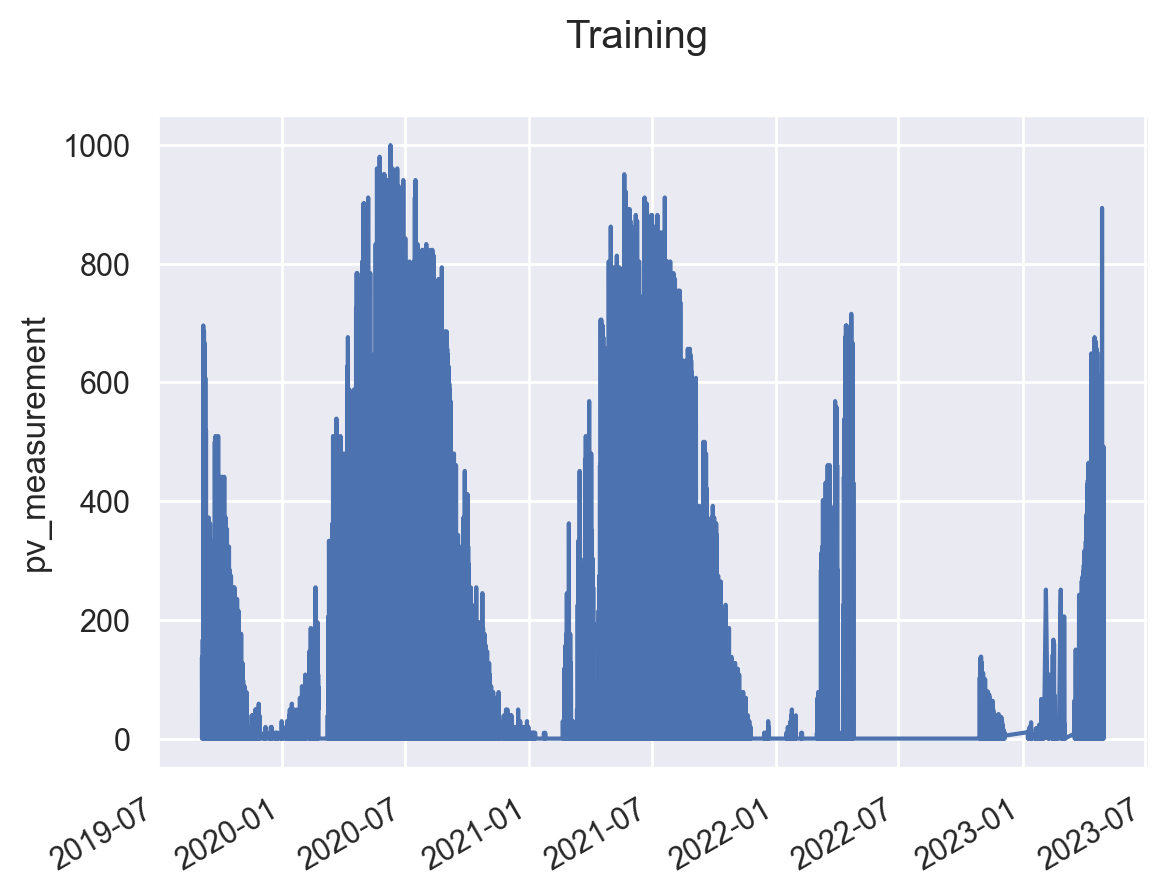

In [6]:
plt.plot(train_c_clean.iloc[:,0], train_c_clean.iloc[:,1])
plt.gcf().autofmt_xdate()
plt.ylabel("pv_measurement")
plt.suptitle("Training")
plt.show()

In [9]:
pred = pd.read_csv(r'Neg_Pow_Inc_0.csv')

In [13]:
pred_c = pred.iloc[(len(pred) - 720):,[1]]

In [14]:
pred_c

,prediction
1440,0.609059
1441,0.109036
1442,0.109036
1443,5.801465
1444,28.574577
...,...
2155,43.273300
2156,18.562958
2157,0.000000
2158,0.005298


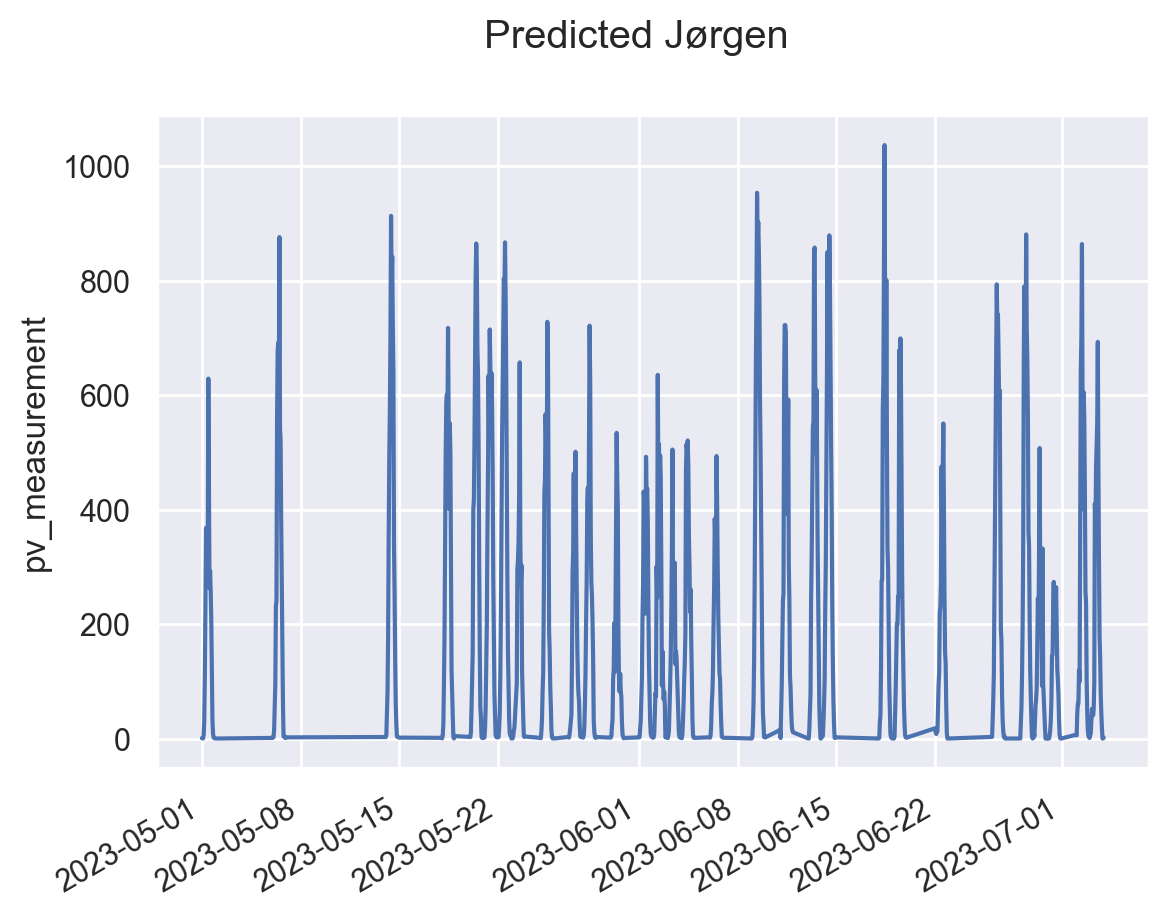

In [18]:
plt.plot(X_test_c_cleanest["date_forecast"],pred_c)
plt.gcf().autofmt_xdate()
plt.ylabel("pv_measurement")
plt.suptitle("Predicted Jørgen")
plt.show()

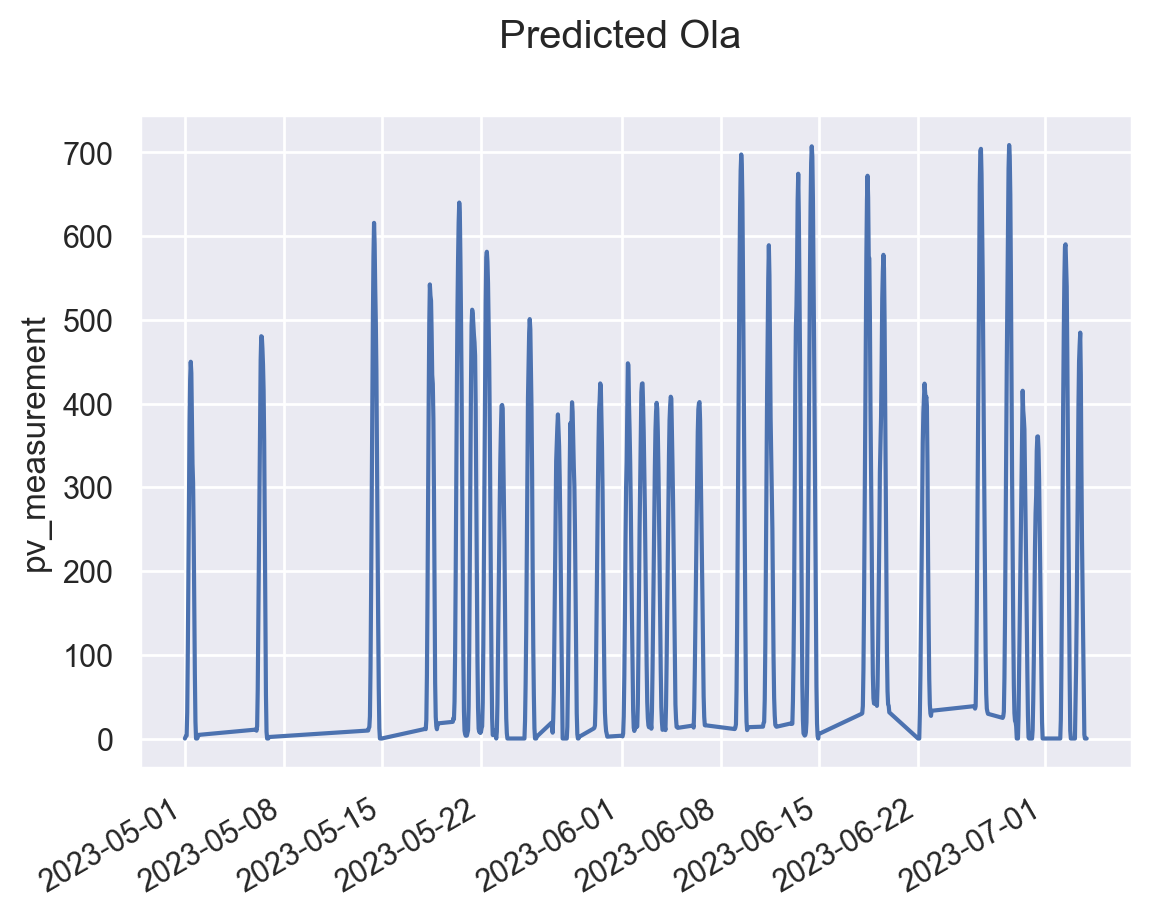

In [17]:
plt.plot(X_test_c_cleanest["date_forecast"],full_model_SARIMAX_c_fit_predicted)
plt.gcf().autofmt_xdate()
plt.ylabel("pv_measurement")
plt.suptitle("Predicted Ola")
plt.show()

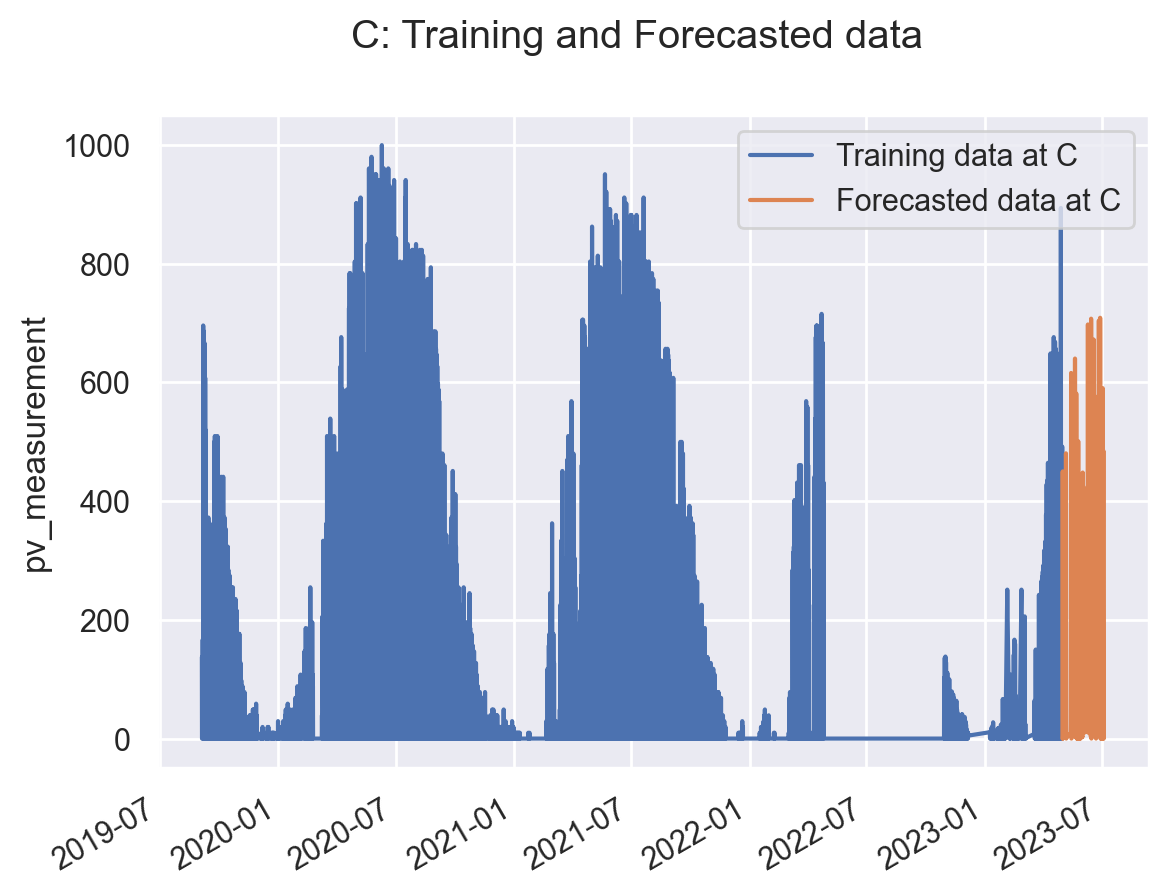

In [80]:

plt.plot(train_c_clean["time"], train_c_clean["pv_measurement"])
plt.plot(full_model_SARIMAX_c_fit_predicted_full["time"], full_model_SARIMAX_c_fit_predicted_full["pv_measurement"])
plt.gcf().autofmt_xdate()
plt.ylabel("pv_measurement")
plt.suptitle("C: Training and Forecasted data")
plt.legend(["Training data at C", "Forecasted data at C"], loc = "upper right")
plt.show()